In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, optimizers, Sequential
from tensorflow.keras import backend as k
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
import pathlib
import glob
from PIL import Image
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense
from tensorflow.keras.losses import SparseCategoricalCrossentropy
import Augmentor
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.applications import VGG16

In [2]:
data_train=pathlib.Path('C:\Lachin\DataSets\cancer\Train')
data_test=pathlib.Path('C:\Lachin\DataSets\cancer\Test')

In [3]:
img_count_train=len(list(data_train.glob('*/*.jpg')))
img_count_test=len(list(data_test.glob('*/*.jpg')))
print(img_count_train)
print(img_count_test)

2581
118


In [4]:
batch_size=32
im_height=180
im_width=180

In [5]:
train_ds=preprocessing.image_dataset_from_directory(data_train,
                                                   seed=123,
                                                   image_size=(im_height,im_width),
                                                   validation_split=0.2,
                                                   subset='training')
#training Data Set

Found 2581 files belonging to 9 classes.
Using 2065 files for training.


In [6]:
valid_ds=preprocessing.image_dataset_from_directory(data_train,
                                                   seed=123,
                                                   image_size=(im_height,im_width),
                                                   validation_split=0.2,
                                                   subset='validation')
#Testing Data Set

Found 2581 files belonging to 9 classes.
Using 516 files for validation.


In [7]:
class_names=train_ds.class_names
print(type(class_names), class_names)

<class 'list'> ['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


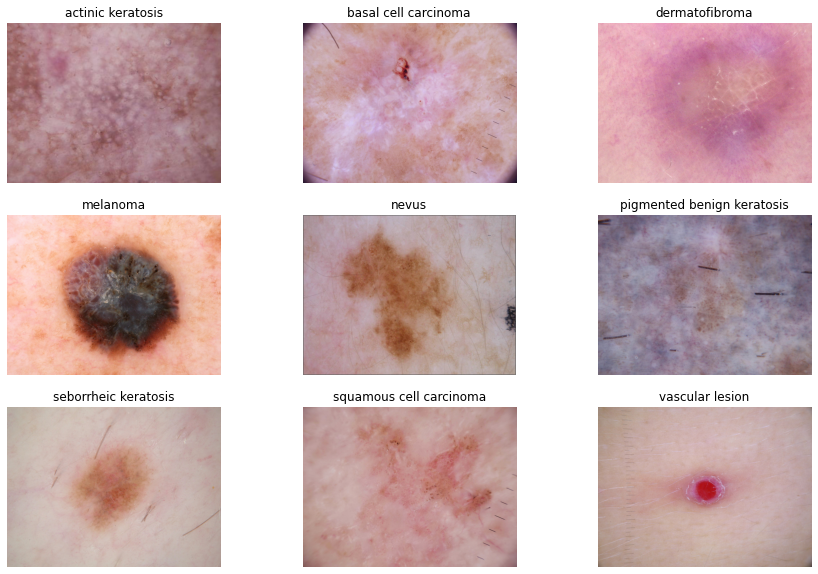

In [8]:
#Visualizalizing results

plt.figure(figsize=(15,10))

for i, class_ in enumerate (list(class_names)):
    plt.subplot(3,3,i+1)
    data_path=os.path.join(str(data_train), class_)
    file_path=glob.glob(os.path.join(data_path,'*.jpg'))[2]
    image=Image.open(file_path)
    plt.imshow(image)
    plt.title(class_)
    plt.axis('off')
plt.show()
    

In [9]:
for image_batch, labels_batch in train_ds.take(1):
    print(image_batch.shape)
    print(labels_batch.shape)
    print(type(labels_batch))
    #image_batch is a tensor of shape(32,180,180,3), 32 is the batch size, 3 is the color range
    #labels_batch is about number of labels

(32, 180, 180, 3)
(32,)
<class 'tensorflow.python.framework.ops.EagerTensor'>


## Validation Split using ImageDaataGenerator

In [10]:
# train_datagen = ImageDataGenerator(rescale=1./255,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True,
#     validation_split=0.2) # set validation split

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='training') # set as training data

validation_generator = train_datagen.flow_from_directory(
    train_data_dir, # same directory as training data
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation') # set as validation data

# model.fit_generator(
#     train_generator,
#     steps_per_epoch = train_generator.samples // batch_size,
#     validation_data = validation_generator, 
#     validation_steps = validation_generator.samples // batch_size,
#     epochs = nb_epochs)

In [11]:
data_augmentation=tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip('horizontal',input_shape=(im_height,im_width,3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.2)
])

In [12]:
AUTOTUNE=tf.data.experimental.AUTOTUNE #API to boost the performance
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
valid_ds=valid_ds.cache().prefetch(buffer_size=AUTOTUNE)

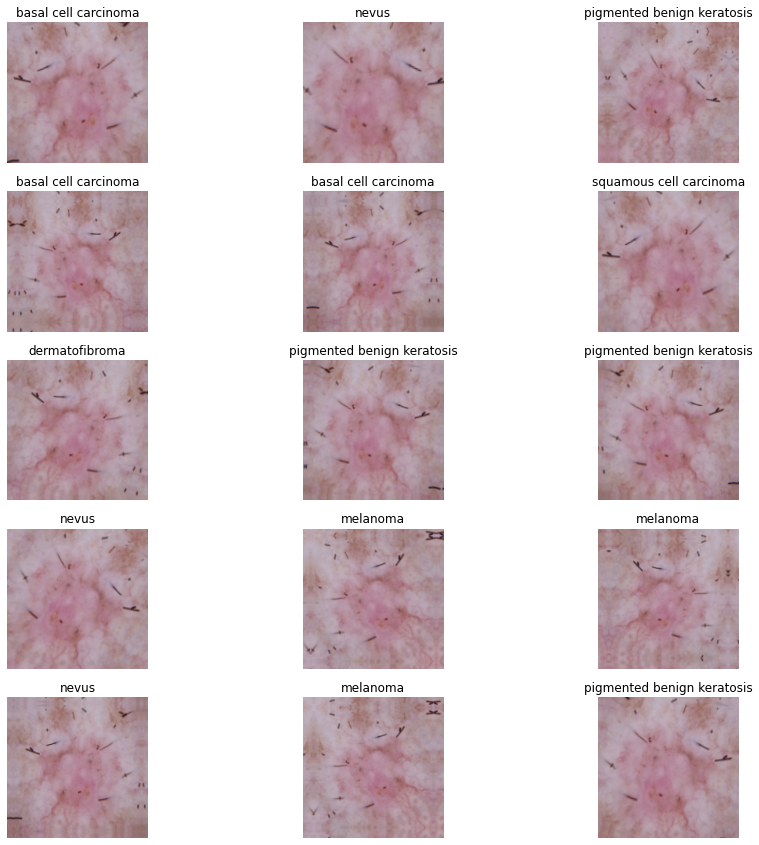

In [13]:
plt.figure(figsize=(15,15))
for images,labels in train_ds.take(1):
    for i in range(15):
        augmented_images=data_augmentation(images)
        plt.subplot(5,3,i+1)
        plt.imshow(augmented_images[0].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis('off')

In [14]:
model=models.Sequential([
    layers.experimental.preprocessing.RandomFlip('horizontal', input_shape=(im_height,im_width,3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
])
model.add(layers.Conv2D(16,(3,3), activation='relu', input_shape=(im_height,im_width,3), padding='same' ))#default padding is valid
model.add(layers.MaxPool2D())
model.add(layers.Dropout(0.25))
model.add(layers.Conv2D(32,(3,3), activation='relu', padding='same' ))
model.add(layers.MaxPool2D())
model.add(layers.Dropout(0.25))
model.add(layers.Conv2D(64,(3,3), activation='relu', padding='same'))
model.add(layers.MaxPool2D())
model.add(layers.Dropout(0.25))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(9, activation='softmax'))

In [15]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
random_flip_1 (RandomFlip)   (None, 180, 180, 3)       0         
_________________________________________________________________
random_rotation_1 (RandomRot (None, 180, 180, 3)       0         
_________________________________________________________________
random_zoom_1 (RandomZoom)   (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)       

In [16]:
model.compile(loss=SparseCategoricalCrossentropy(from_logits=True), optimizer='adam', metrics='accuracy')

In [19]:
epochs=20
model_train=model.fit(train_ds, epochs=epochs, validation_data=valid_ds)

Epoch 1/20
65/65 [==============================] - 33s 510ms/step - loss: 1.5733 - accuracy: 0.4228 - val_loss: 1.7781 - val_accuracy: 0.3469
Epoch 2/20
65/65 [==============================] - 36s 551ms/step - loss: 1.5687 - accuracy: 0.4169 - val_loss: 1.6950 - val_accuracy: 0.3566
Epoch 3/20
65/65 [==============================] - 36s 557ms/step - loss: 1.5428 - accuracy: 0.4252 - val_loss: 1.7574 - val_accuracy: 0.3643
Epoch 4/20
65/65 [==============================] - 36s 553ms/step - loss: 1.5093 - accuracy: 0.4271 - val_loss: 1.6385 - val_accuracy: 0.3953
Epoch 5/20
65/65 [==============================] - 36s 557ms/step - loss: 1.5198 - accuracy: 0.4334 - val_loss: 1.6307 - val_accuracy: 0.3934
Epoch 6/20
65/65 [==============================] - 39s 594ms/step - loss: 1.4943 - accuracy: 0.4431 - val_loss: 1.6849 - val_accuracy: 0.4031
Epoch 7/20
65/65 [==============================] - 39s 599ms/step - loss: 1.4679 - accuracy: 0.4494 - val_loss: 1.6421 - val_accuracy: 0.3895

Text(0.5, 1.0, 'Training & Validation losses')

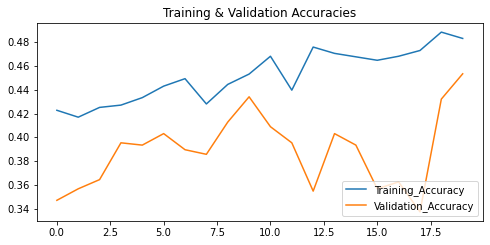

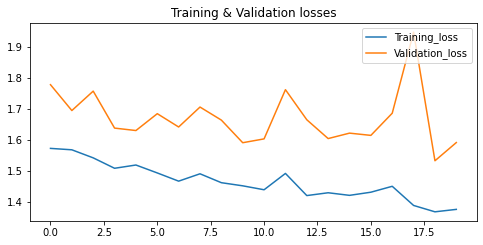

In [20]:
epo_range=range(epochs)
acc=model_train.history['accuracy']
val_acc=model_train.history['val_accuracy']

loss=model_train.history['loss']
val_loss=model_train.history['val_loss']

plt.figure(figsize=(8,8))
plt.subplot(2,1,1)
plt.plot(epo_range,acc, label='Training_Accuracy')
plt.plot(epo_range, val_acc, label='Validation_Accuracy')
plt.legend(loc='lower right')
plt.title('Training & Validation Accuracies')

plt.figure(figsize=(8,8))
plt.subplot(2,1,2)
plt.plot(epo_range,loss, label='Training_loss')
plt.plot(epo_range, val_loss, label='Validation_loss')
plt.legend(loc='upper right')
plt.title('Training & Validation losses')



In [14]:
class_size={}
for i in class_names:
    class_size[i]=len(list(data_train.glob(i + '/*.jpg')))

In [15]:
class_size

{'actinic keratosis': 456,
 'basal cell carcinoma': 376,
 'dermatofibroma': 95,
 'melanoma': 438,
 'nevus': 357,
 'pigmented benign keratosis': 462,
 'seborrheic keratosis': 77,
 'squamous cell carcinoma': 181,
 'vascular lesion': 139}

In [16]:
class_size.items()

dict_items([('actinic keratosis', 456), ('basal cell carcinoma', 376), ('dermatofibroma', 95), ('melanoma', 438), ('nevus', 357), ('pigmented benign keratosis', 462), ('seborrheic keratosis', 77), ('squamous cell carcinoma', 181), ('vascular lesion', 139)])

In [17]:
print(class_size.keys())
print(class_size.values())

dict_keys(['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion'])
dict_values([456, 376, 95, 438, 357, 462, 77, 181, 139])


In [18]:
class_df=pd.DataFrame(class_size.items(), index=list(class_size), columns=['ClassNames','NumberofSamples'])

In [19]:
class_df

,ClassNames,NumberofSamples
actinic keratosis,actinic keratosis,456
basal cell carcinoma,basal cell carcinoma,376
dermatofibroma,dermatofibroma,95
melanoma,melanoma,438
nevus,nevus,357
pigmented benign keratosis,pigmented benign keratosis,462
seborrheic keratosis,seborrheic keratosis,77
squamous cell carcinoma,squamous cell carcinoma,181
vascular lesion,vascular lesion,139


In [20]:
class_df.drop('ClassNames', axis=1, inplace=True)

In [21]:
class_df

,NumberofSamples
actinic keratosis,456
basal cell carcinoma,376
dermatofibroma,95
melanoma,438
nevus,357
pigmented benign keratosis,462
seborrheic keratosis,77
squamous cell carcinoma,181
vascular lesion,139


<AxesSubplot:>

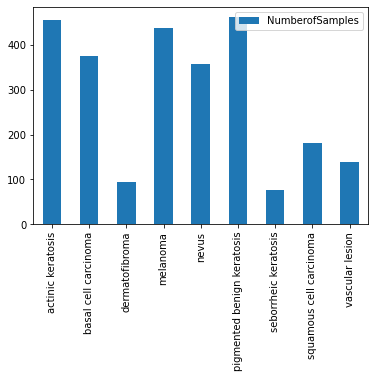

In [22]:
class_df.plot.bar()

In [73]:
path_train='C:/Lachin/DataSets/cancer/Train/'

In [74]:
for i in class_names:
    p=Augmentor.Pipeline(path_train + i, output_directory=os.path.join('C:\Lachin\DataSets\cancer\Aug data\Train',i))
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(1000)

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x1D280E25790>:   2%|▏         | 15/1000 [00:00<01:40,  9.77 Samples/s]

Initialised with 456 image(s) found.
Output directory set to C:\Lachin\DataSets\cancer\Aug data\Train\actinic keratosis.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1D280E214C0>: 100%|██████████| 1000/1000 [00:08<00:00, 120.55 Samples/s]                 
Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1D25B88B910>:   1%|          | 9/1000 [00:00<01:58,  8.35 Samples/s]                  

Initialised with 376 image(s) found.
Output directory set to C:\Lachin\DataSets\cancer\Aug data\Train\basal cell carcinoma.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1D262B06160>: 100%|██████████| 1000/1000 [00:10<00:00, 96.34 Samples/s]                  
Executing Pipeline:   0%|          | 0/1000 [00:00<?, ? Samples/s]

Initialised with 95 image(s) found.
Output directory set to C:\Lachin\DataSets\cancer\Aug data\Train\dermatofibroma.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x1D262AE3B80>: 100%|██████████| 1000/1000 [00:12<00:00, 77.27 Samples/s]
Executing Pipeline:   0%|          | 0/1000 [00:00<?, ? Samples/s]

Initialised with 438 image(s) found.
Output directory set to C:\Lachin\DataSets\cancer\Aug data\Train\melanoma.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x1D280E31820>: 100%|██████████| 1000/1000 [00:59<00:00, 16.71 Samples/s]
Executing Pipeline:   0%|          | 0/1000 [00:00<?, ? Samples/s]

Initialised with 357 image(s) found.
Output directory set to C:\Lachin\DataSets\cancer\Aug data\Train\nevus.

Processing <PIL.Image.Image image mode=RGB size=957x640 at 0x1D25E95D280>: 100%|██████████| 1000/1000 [01:00<00:00, 16.56 Samples/s]                   
Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1D280E3BDF0>:   0%|          | 5/1000 [00:00<01:50,  9.03 Samples/s]                  

Initialised with 462 image(s) found.
Output directory set to C:\Lachin\DataSets\cancer\Aug data\Train\pigmented benign keratosis.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x1D262C93A00>: 100%|██████████| 1000/1000 [00:12<00:00, 81.45 Samples/s]
Executing Pipeline:   0%|          | 0/1000 [00:00<?, ? Samples/s]

Initialised with 77 image(s) found.
Output directory set to C:\Lachin\DataSets\cancer\Aug data\Train\seborrheic keratosis.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x1D25E9467F0>: 100%|██████████| 1000/1000 [00:27<00:00, 36.38 Samples/s]                 
Executing Pipeline:   0%|          | 0/1000 [00:00<?, ? Samples/s]

Initialised with 181 image(s) found.
Output directory set to C:\Lachin\DataSets\cancer\Aug data\Train\squamous cell carcinoma.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1D260B9A790>: 100%|██████████| 1000/1000 [00:12<00:00, 81.31 Samples/s]                 
Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1D2339A7160>:   0%|          | 3/1000 [00:00<02:20,  7.08 Samples/s]                  

Initialised with 139 image(s) found.
Output directory set to C:\Lachin\DataSets\cancer\Aug data\Train\vascular lesion.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1D25B896D90>: 100%|██████████| 1000/1000 [00:11<00:00, 83.50 Samples/s]                 


In [23]:
train_directory='C:\Lachin\DataSets\cancer\Aug data\Train'

In [24]:
train_datagen=ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    validation_split=0.2,
    horizontal_flip=True)

In [44]:
batch_size1=21
train_generator=train_datagen.flow_from_directory(
    train_directory, 
    target_size=(im_height,im_width), 
    batch_size=batch_size1, 
    class_mode='categorical',
    subset='training')
valid_generator=train_datagen.flow_from_directory(
    train_directory, 
    target_size=(im_height,im_width), 
    batch_size=batch_size1, 
    class_mode='categorical',
    subset='validation')

Found 7200 images belonging to 9 classes.
Found 1800 images belonging to 9 classes.


In [45]:
model=Sequential()
model.add(layers.Conv2D(16,(3,3), activation='relu', input_shape=(im_height,im_width,3), padding='same' ))#default padding is valid
model.add(layers.MaxPool2D())
model.add(layers.Conv2D(32,(3,3), activation='relu', padding='same' ))
model.add(layers.MaxPool2D())
model.add(layers.Conv2D(64,(3,3), activation='relu', padding='same'))
model.add(layers.MaxPool2D())
model.add(layers.Dropout(0.25))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(9, activation='softmax'))

In [46]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 22, 22, 64)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 22, 22, 64)       

In [47]:
AUTOTUNE=tf.data.experimental.AUTOTUNE #API to boost the performance
train_generator=train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
valid_generator=valid_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [48]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics='accuracy')

In [50]:
epochs=20
model_train1=model.fit_generator(train_generator,epochs=epochs, validation_data=valid_generator)

Epoch 1/20
65/65 [==============================] - 25s 380ms/step - loss: 1.6325 - accuracy: 0.4116 - val_loss: 1.7555 - val_accuracy: 0.3547
Epoch 2/20
65/65 [==============================] - 28s 428ms/step - loss: 1.4331 - accuracy: 0.5002 - val_loss: 1.5758 - val_accuracy: 0.4496
Epoch 3/20
65/65 [==============================] - 28s 426ms/step - loss: 1.2546 - accuracy: 0.5453 - val_loss: 1.4878 - val_accuracy: 0.4981
Epoch 4/20
65/65 [==============================] - 28s 438ms/step - loss: 1.1092 - accuracy: 0.6024 - val_loss: 1.4968 - val_accuracy: 0.5078
Epoch 5/20
65/65 [==============================] - 28s 432ms/step - loss: 1.0119 - accuracy: 0.6426 - val_loss: 1.5665 - val_accuracy: 0.5097
Epoch 6/20
65/65 [==============================] - 28s 428ms/step - loss: 0.8761 - accuracy: 0.6954 - val_loss: 1.6288 - val_accuracy: 0.5019
Epoch 7/20
65/65 [==============================] - 28s 427ms/step - loss: 0.7561 - accuracy: 0.7308 - val_loss: 1.7610 - val_accuracy: 0.4942

Text(0.5, 1.0, 'Training & Validation losses')

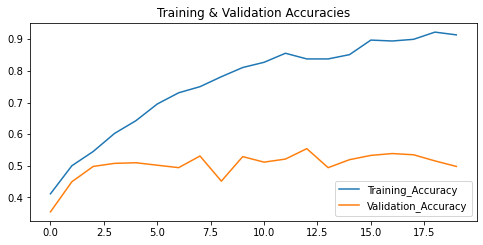

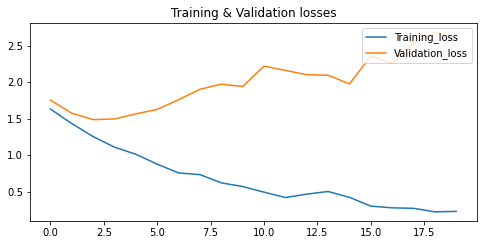

In [51]:
epo_range=range(epochs)
acc=model_train1.history['accuracy']
val_acc=model_train1.history['val_accuracy']

loss=model_train1.history['loss']
val_loss=model_train1.history['val_loss']

plt.figure(figsize=(8,8))
plt.subplot(2,1,1)
plt.plot(epo_range,acc, label='Training_Accuracy')
plt.plot(epo_range, val_acc, label='Validation_Accuracy')
plt.legend(loc='lower right')
plt.title('Training & Validation Accuracies')

plt.figure(figsize=(8,8))
plt.subplot(2,1,2)
plt.plot(epo_range,loss, label='Training_loss')
plt.plot(epo_range, val_loss, label='Validation_loss')
plt.legend(loc='upper right')
plt.title('Training & Validation losses')


In [52]:
#VGG16
conv_base=VGG16(weights='imagenet',include_top=False,input_shape=(im_height,im_width,3))

In [53]:
model=models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(9, activation='softmax'))

In [54]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 5, 5, 512)         14714688  
_________________________________________________________________
flatten_4 (Flatten)          (None, 12800)             0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 12800)             0         
_________________________________________________________________
dense_8 (Dense)              (None, 256)               3277056   
_________________________________________________________________
dense_9 (Dense)              (None, 9)                 2313      
Total params: 17,994,057
Trainable params: 17,994,057
Non-trainable params: 0
_________________________________________________________________


In [55]:
AUTOTUNE=tf.data.experimental.AUTOTUNE #API to boost the performance
train_generator=train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
valid_generator=valid_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [56]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics='accuracy')

In [ ]:
epochs=15
model_train1=model.fit_generator(train_generator,epochs=epochs, validation_data=valid_generator)

Epoch 1/15
65/65 [==============================] - 818s 13s/step - loss: 2.3945 - accuracy: 0.1617 - val_loss: 2.1468 - val_accuracy: 0.1919
Epoch 2/15
65/65 [==============================] - 818s 13s/step - loss: 2.1218 - accuracy: 0.1763 - val_loss: 2.1037 - val_accuracy: 0.1783
Epoch 3/15
65/65 [==============================] - 808s 12s/step - loss: 2.0858 - accuracy: 0.1792 - val_loss: 2.0798 - val_accuracy: 0.1783
Epoch 4/15
65/65 [==============================] - 829s 13s/step - loss: 2.0646 - accuracy: 0.1792 - val_loss: 2.0667 - val_accuracy: 0.1783
Epoch 5/15
38/65 [================>.............] - ETA: 5:13 - loss: 2.0563 - accuracy: 0.1801